This notebook is an application of the [lvlspy API](https://pypi.org/project/lvlspy/), a tool developed to handle quantum level data. Tutorials on how to use the API are found [here](https://github.com/jaadt7/lvlspy_tutorial). 

The API will be used to replicate the results found in [Gupta and Meyer](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.64.025805) with the most recent ENSDF data for $^{26}\mathrm{Al}$

To start things off, we will quietly install and import the required packages that will be used throughout the notebook

In [1]:
import sys, subprocess,pkg_resources,io,requests
required = {'numpy','matplotlib','lvlspy','ipython','tabulate','scipy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import heapq
import tabulate
import numpy as np
import lvlspy.spcoll as lc
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy.integrate import odeint
from IPython.display import HTML, display, Math

Here we will set up the level system for $^{26}\mathrm{Al}$. We will read an xml generated by the tutorial mentioned above.

In [2]:
new_coll = lc.SpColl() #sets up the collection of species
new_coll.update_from_xml('nuc_data_test.xml') #reads in the xml, this might take some time depending on the size of the file
al26 = new_coll.get()['al26'] #sets the species object to the species in the collection

The aim of the paper is to solve for the equilibration rate between the isomeric state and the ground state. To figure out which level that is, we can print it out

In [3]:
levels = al26.get_levels()
for lev in levels:
    if 'isomer' in lev.get_properties():
        print('Level: '+  str(levels.index(lev)) + ' is an isomer level') 

Level: 1 is an isomer level


It's important to get which level is the isomeric state because it is not always the case the isomer is the 1st excited state, and some isotopes have more than one. Now that we know which level, is the isomer level, let's calculate the equilibration rate between it and the ground state as a function of temperature. The method itself is adaptable to work with any level and the ground state.

We define the generalized functions according to the methods defined in the aforementioned paper. The transfer properties function takes the rate matrix as input and extracts the Destruction Matrix diagonal, and sets up the Transfer matrix and the Production vectors. In the paper, the 'ij' subscripts refer to transitions from level 'i' into level 'j'. This however does not correspond to the 'ith' row and 'jth' column of the matrix. The index swap in the function takes care of this change.

In the lambda_effective function, the effective decay rate and the excitation rate are calculated between the ground and isomeric state. However, this notebook deviates from the method described in the paper by ignoring the approximation surrounding $(I - F^{T})^{-1}$ and calculates it directly. This leads to a change of form for $\lambda_{12}^{eff}$ and $\lambda_{21}^{eff}$ to $\Lambda_{1}(1 - (f_{1}^{in})^{T}(I - F^{T})^{-1})f_{1}^{out}$ and $\Lambda_{2}(f_{1}^{in})^{T}(I - F^{T})^{-1}f_{2}^{out}$ respectively.

In [4]:
def transfer_properties(rate_matrix,level_low,level_high):
    #setting in the rates going in to the levels   
    lambda_low_in  = rate_matrix[level_low,:]
    lambda_high_in = rate_matrix[level_high,:]

    #remove entries corresponding the rows and columns to be removed
    lambda_low_in  = np.delete(lambda_low_in,[level_low,level_high])
    lambda_high_in = np.delete(lambda_high_in,[level_low,level_high])
    
    #setting the rates going out of the levels
    lambda_low_out  = rate_matrix[:,level_low]
    lambda_high_out = rate_matrix[:,level_high]

    #remove entries corresponding to the rows and columns to be removed
    lambda_low_out  = np.delete(lambda_low_out,[level_low,level_high])
    lambda_high_out = np.delete(lambda_high_out,[level_low,level_high])

    #extract the diagonal elements from the rate matrix as they are the sum of all the rates into the level
    LAMBDA     = np.diag(rate_matrix)
    #this array is the reduced array above without the removed levels
    LAMBDA_red = np.delete(LAMBDA,[level_low,level_high]) 
    
    f_low_out  = lambda_low_out/LAMBDA[level_low]
    f_high_out = lambda_high_out/LAMBDA[level_high]

    f_low_in  = lambda_low_in/LAMBDA_red
    f_high_in = lambda_high_in/LAMBDA_red

    #setting up the transfer matrix
    F = rate_matrix
    F = F.T
    #remove the columns
    F = np.delete(F,[level_low,level_high],axis = 1)
    #remove the rows
    F = np.delete(F,[level_low,level_high], axis = 0)

    #Divide the row by the diagonal term
    F = F/LAMBDA_red[:,None] #This only works if the arrays are numpy arrays

    #set the diagonal to 0
    np.fill_diagonal(F,0.0)
    #take the transpose
    
    return F,f_low_in,f_low_out,f_high_in,f_high_out,LAMBDA
########################################################################################################
#This function calculates the effective transition rates in and out between the ground and isomer states
def lambda_effective(T,sp,level_low,level_high):
    # the subscripts 1 and 2 are generic. They designate the lower and upper levels respectively
    rate_matrix = np.abs(sp.compute_rate_matrix(T))
    F,f_low_in,f_low_out,f_high_in,f_high_out,LAMBDA = transfer_properties(rate_matrix,level_low,level_high)
    n = len(F)
    #Lambda_21_eff
    l_high_low = LAMBDA[level_high]* np.matmul(f_low_in,np.matmul(np.linalg.inv(np.identity(n) - F.T),f_high_out))
    #Lambda_12_eff
    l_low_high = LAMBDA[level_low]*(1.0 - np.matmul(f_low_in,np.matmul(np.linalg.inv(np.identity(n) - F.T),f_low_out)))
            
    return l_low_high,l_high_low

Now that the functions are defined and we know which two levels we want to find the rate between. Let's set a temperature range and graph the results

In [5]:
#Temperature Range in K
T = np.logspace(8,10)

#upper and lower level
l_high = 1 #first excited state as found from above
l_low = 0 #ground state

#initializing the rate arrays as a function of temperature
lambda_21_eff = np.empty(len(T))
lambda_12_eff = np.empty(len(T))

#Calculating the effective transition rates
for i,t in enumerate(T):
    lambda_12_eff[i],lambda_21_eff[i] = lambda_effective(t,al26,l_low,l_high)

The graphing portion is separated for convenience sake

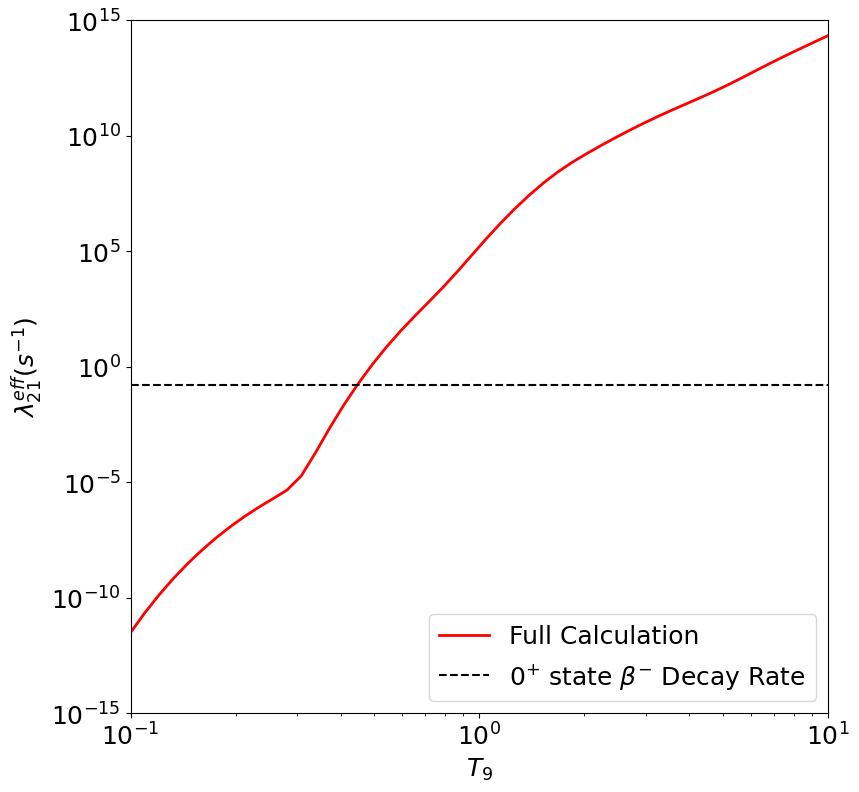

In [6]:
fontsize = 18

plt.figure(figsize = (9,9))
plt.rcParams['font.size'] = fontsize
plt.xscale('log')
plt.yscale('log')

plt.ylim([1.e-15,1.e+15])
plt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])

plt.plot(T/1e+9,lambda_21_eff,color = 'red',linewidth = 2,label = 'Full Calculation')

plt.ylabel(r'$\lambda_{21}^{eff} (s^{-1})$')
plt.xlabel(r'$T_{9}$')

plt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])

plt.axhline(y = 0.158,ls = '--',color = 'black',label = r'$0^{+}$ state $\beta^{-}$ Decay Rate')

plt.legend(loc = 'lower right')
plt.show()

Comparing to figure 1 in the paper, you notice that the rate is slightly lower at the lower end. This is due to the fact that this xml has 160 evaluated levels while the paper had only 67 at the time of writing. The decay rate of the $0^{+}$ acts an indicator for behavioral change. For $T_{9} < \mathrm{0.35}$, the isomeric state will beta-decay while out of Boltzmann equilibrium. This means the isomer must be treated separately from the ground state in the nuclear network with that temperature ceiling. Beyond that, the equilibration rate is higher than the beta decay rate of the isomer, which means the isomer will be in Boltzmann equilibrium with the ground state and needs not be treated separately in the network. 

The API can also be used to test the contribution of specific transitions to the overall equilibration rate. The cell below illustrates this by removing certain transitions connecting upper lying levels to the isomeric state. The transition removed is then returned before the next one is removed

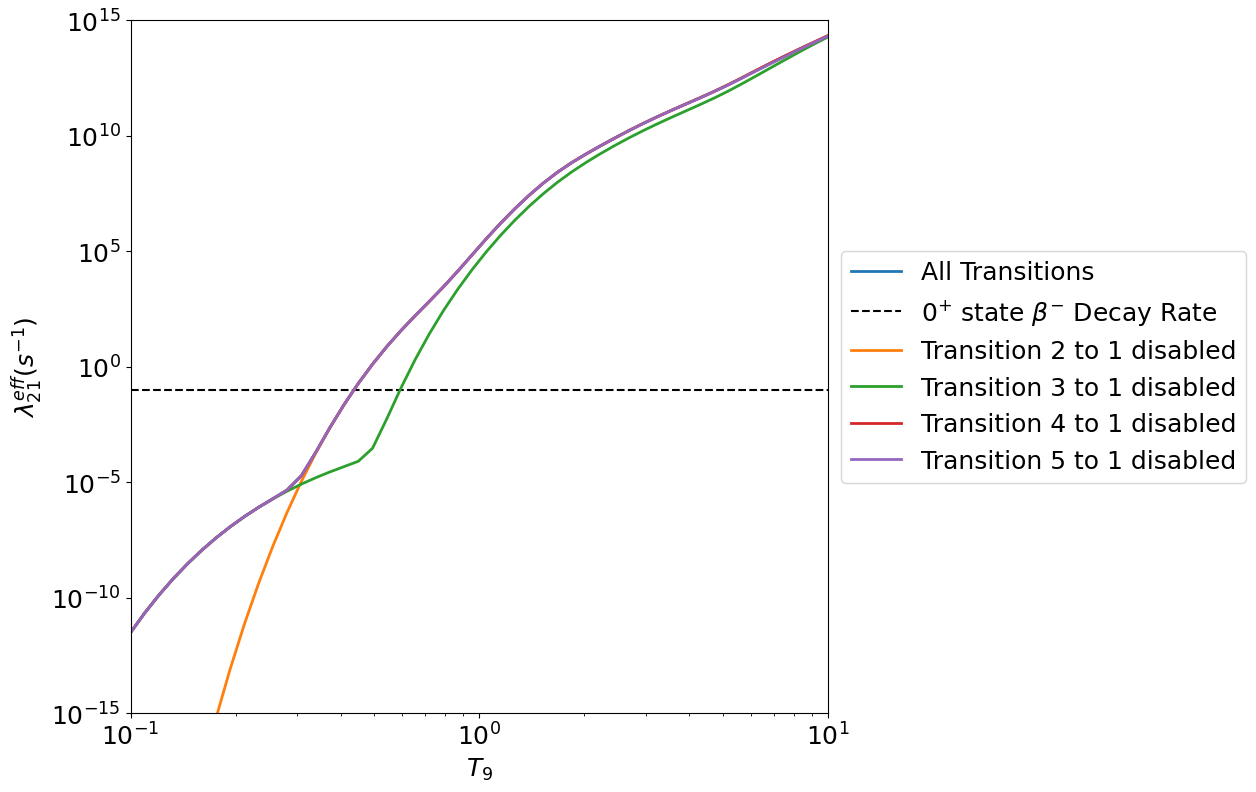

In [7]:
#setting the graph with the original calculation

plt.figure(figsize = (9,9))
plt.rcParams['font.size'] = fontsize
plt.xscale('log')
plt.yscale('log')

plt.ylim([1.e-15,1.e+15])
plt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])

plt.plot(T/1e+9,lambda_21_eff,linewidth = 2,label = 'All Transitions')

plt.ylabel(r'$\lambda_{21}^{eff} (s^{-1})$')
plt.xlabel(r'$T_{9}$')

plt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])

plt.axhline(y = 1.e-1,ls = '--',color = 'black',label = r'$0^{+}$ state $\beta^{-}$ Decay Rate')

#removing transitions, graphing the result, then returning it before removing the next
for i in range(2,6):
    t_remove = al26.get_level_to_level_transition(levels[i],levels[1])
    #removing the transition
    al26.remove_transition(t_remove)
    lambda_21_eff = np.empty(len(T))
    lambda_12_eff = np.empty(len(T)) 
    for j,t in enumerate(T):
        lambda_12_eff[j],lambda_21_eff[j] = lambda_effective(t,al26,l_low,l_high)
    #adding it back after the calculations
    al26.add_transition(t_remove)
    plt.plot(T/1e+9,lambda_21_eff,linewidth = 2,label = 'Transition '+str(i)+ ' to 1 disabled')

plt.legend(loc = 'center left',bbox_to_anchor=(1,0.5))
plt.show()

Out of the selected rates, it is clear that the transitions from the 2nd excited state to the 1st and that from the 3rd down to the 1st have a substantial effect on the equilibration rate at $T_{9} \approx \mathrm{0.4} $. This is a potential diagnostic to guide experimentalists to decide which energy levels need to be deteremined to high accuracy.

You can evolve the entire system of 160 levels directly with the rate matrix via the system of coupled equations $\frac{dY}{dt} = \Lambda Y$. Y represents the abundance of a given level and $\Lambda$ is the rate matrix of the system

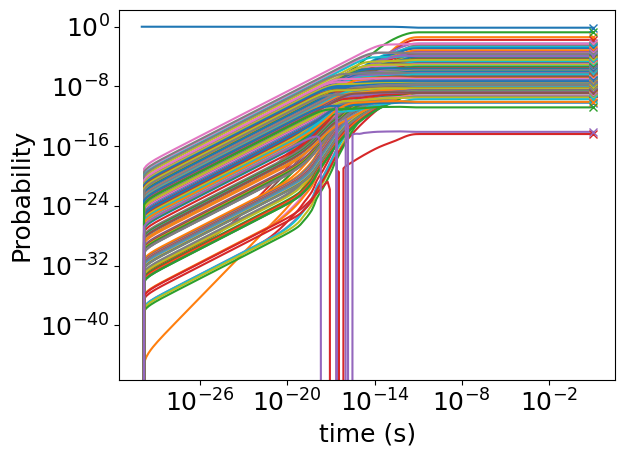

In [8]:
def deri_func(y,t,rate_matrix): #function that calculates the derivatives for odeint
    return rate_matrix.dot(y)
#set time interval
t_begin = 1.e-30
t_end = 10
n_steps = 200
t = np.logspace(np.log10(t_begin), np.log10(t_end), n_steps) #logarithmic space was chosen to smoothen out the graphs at small timescales
#set the temperature to evolve the system
T9 = 5 #temperature in billions of kelvin
#compute rate matrix
rate_matrix = al26.compute_rate_matrix(T9*1e+9)
#compute equilibrium probabilities
eq_probs = al26.compute_equilibrium_probabilities(T9*1e+9)

#set the initial conditions
y = np.zeros(rate_matrix.shape[0])
y[0] = 1

#solve and graph
sol_odeint = odeint(deri_func,y,t,args=(rate_matrix,))
for i in range(sol_odeint.shape[1]): #graph the 1st 5 levels for clarity
    plt.plot(t,sol_odeint[:,i],label = 'Level: ' + str(i))

plt.gca().set_prop_cycle(None) # Reset color cycle to align equilibria with network solutions
for i in range(sol_odeint.shape[1]):
    plt.plot(t[t.shape[0]-1], eq_probs[i], 'x')
    
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1.e-15, 100])
plt.xlabel('time (s)')
plt.ylabel('Probability')
#plt.legend(loc = 'center left',bbox_to_anchor=(1,0.5))
plt.show()


All 160 levels from the xml have been evolved to their predicted equilibria. For clarity, a selection of levels will be graphed again below

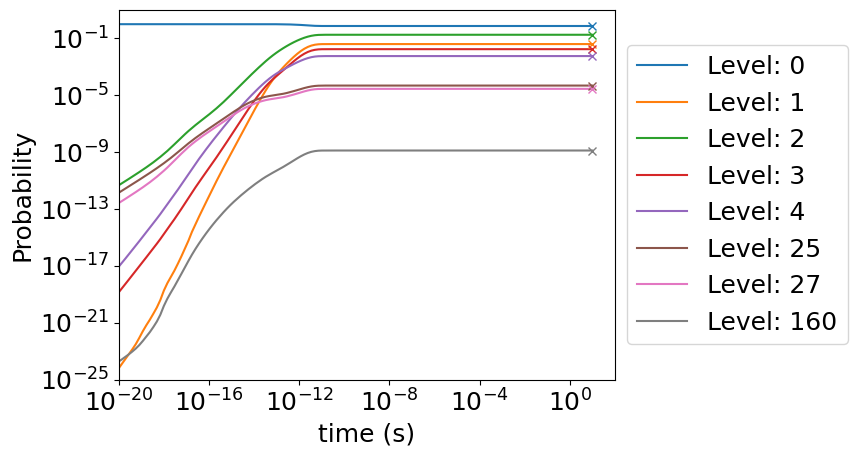

In [9]:
l_range = [0,1,2,3,4,25,27, ]
for i in l_range: #graph the 1st 5 levels for clarity
    plt.plot(t,sol_odeint[:,i],label = 'Level: ' + str(i))

plt.gca().set_prop_cycle(None) # Reset color cycle to align equilibria with network solutions
for i in l_range:
    plt.plot(t[t.shape[0]-1], eq_probs[i], 'x')
    
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.e-20, 100])
plt.ylim([1e-25,10])
plt.xlabel('time (s)')
plt.ylabel('Probability')
plt.legend(loc = 'center left',bbox_to_anchor=(1,0.5))
plt.show()

The effective rate could be understood via a combinatorial interpretation. The expression $(f_{1}^{in})^{T}(I - F^{T})^{-1}f_{2}^{out}$ from $\lambda_{21}^{eff}$ is actually the effective branching ratio in terms of Graph Theory. The "cascade probability vectors" are defined as $\Gamma_{q}^{in} = (I - F)^{-1}f_{q}^{in}$. The term cascade refers to the de-excitation from higher states into state 'q'. The paper also defines the 'infinite'-arc generalization of $f_{q}^{out}$ with $\Gamma_{q}^{out} = (I - F^{T})^{-1}f_{q}^{out}$. They then go through the proof to rewrite $\lambda_{21}^{eff} = (\lambda_{2}^{out})^{T}\Gamma_{1}^{in}$.

In [10]:
def gamma_calculator(T,sp,level_low,level_high):
    rate_matrix = np.abs(sp.compute_rate_matrix(T))
    F,f_low_in,f_low_out,f_high_in,f_high_out,LAMBDA = transfer_properties(rate_matrix,level_low,level_high)

    n = len(F)

    #gamma in
    g_low_in = np.matmul(np.linalg.inv(np.identity(n) - F),f_low_in)
    g_high_in = np.matmul(np.linalg.inv(np.identity(n) - F),f_high_in)

    #gamma out
    g_low_out = np.matmul(np.linalg.inv(np.identity(n) - F.T),f_low_out)
    g_high_out = np.matmul(np.linalg.inv(np.identity(n) - F.T),f_high_out)

    return g_low_out,g_low_in,g_high_out,g_high_in

Other than cleaning up the expression for the effective rates, the $\Gamma$'s play another role, that of calculating the fugacity of each state. Fugacity here deviates away from the pressure definition it uses in thermodynamics, but the term was appropriated due to its description of a state's abundance likeliness to jump to another state with less fugacity. If two states have the same fugacity, they will not exchange abundances. Equilibrium is established when all states have the same fugacity of one.